In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Normal SQL
# engine.execute("SELECT * FROM measurement LIMIT 5")

# ORM -> Object Relational Mapper
# session.query(Measurement)

# Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).first()

('2017-08-23',)

Text(0, 0.5, 'Percipitation in Inches')

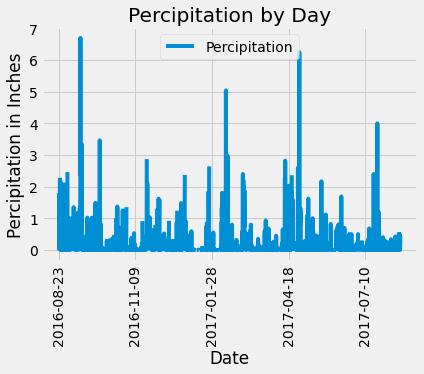

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year = dt.date(2017, 8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
percep_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year).all()

# Select date, prcp
# FROM Measurement
# WHERE date >= 2016-08-23

# Save the query results as a Pandas DataFrame and set the index to the date column
percep_df = pd.DataFrame(percep_data, columns=["Date", "Percipitation"])
percep_df.set_index("Date", inplace=True)
percep_df

# Sort the dataframe by date
percep_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
percep_df.plot(rot=90)
plt.title("Percipitation by Day")
plt.ylabel("Percipitation in Inches")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percep_df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all() 



[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# USC00519281

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

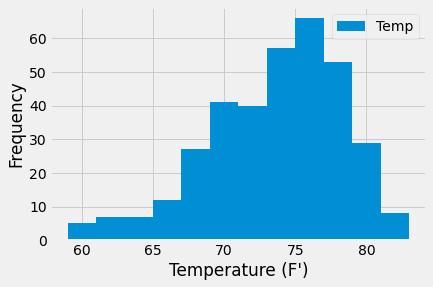

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= previous_year).filter(Measurement.station == 'USC00519281').all()
most_active_df = pd.DataFrame(most_active, columns=["Date", "Temp"])
most_active_df.set_index("Date", inplace=True)
most_active_df.sort_index(inplace=True)

most_active_df.plot.hist(bins=12)
plt.xlabel("Temperature (F')")
plt.ylabel("Frequency")


# Temperature Analysis 

In [16]:
# This Function Called `calc_temps` Will Accept Start Date and End Date in the Format `%Y-%m-%d` 
# and Return the Minimum, Average, and Maximum Temperatures for that Range of Dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function Usage Example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use the `calc_temps` Function to Calculate the min, avg, and max Temperatures for Your Trip 
# Using the Previous Year's Data for Those Same Dates
my_trip = calc_temps("2017-03-14", "2017-03-28")
my_trip

[(65.0, 73.12222222222222, 80.0)]

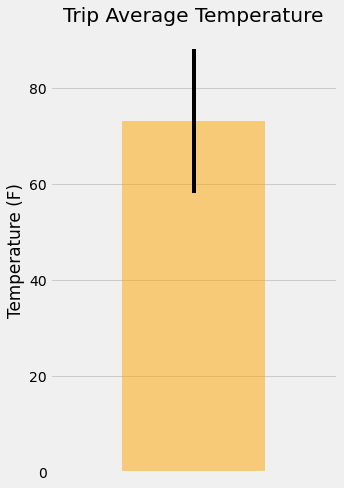

In [25]:
# Load the Results as a Pandas DataFrame
my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])

# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart
# Use "Trip Average Temperature" as the Title
# Use the Average Temperature for the y Value
# Use the Peak-to-Peak (max-min) Value as the y Error Bar
my_trip_df.plot.bar(y="TAVG", yerr=(my_trip_df["TMAX"] - my_trip_df["TMIN"]), 
                    title="Trip Average Temperature", color="orange", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.show()